In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 15490 (delta 10), reused 23 (delta 9), pack-reused 15460
Receiving objects: 100% (15490/15490), 14.10 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (10395/10395), done.


* train, test, valid 폴더에 있는 images, labels 데이터를 모두 한 폴더에 모아보자.

`mkdir()`
* 현재 디렉토리에 폴더를 생성한다.

In [5]:
#다크넷에 images 폴더를 생성해서 데이터 압축풀어주기
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/split(0.6 0.2 02.)_crop/images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/darknet/data/images')

In [6]:
a = os.listdir('/content/darknet/data/images')
a

['H_8204.20-0000_09_741.txt',
 'H_8207.50-1090_16_224.jpg',
 'H_9405.40-9000_20_205.jpg',
 'S_8471.30-0000_26_502.jpg',
 'H_8205.40-0000_21_490.txt',
 'H_8213.00-1000_24_296.txt',
 'H_8202.39-2090_13_652.jpg',
 'H_8214.20-0000_02_406.txt',
 'H_8213.00-1000_11_096.jpg',
 'H_8203.20-1000_20_441.txt',
 'H_8424.90-2000_01_064.jpg',
 'H_8213.00-1000_32_278.txt',
 'H_8201.40-0000_10_243.jpg',
 'H_8213.00-1000_21_788.jpg',
 'H_9306.30-9000_14_287.txt',
 'H_8205.20-0000_04_445.jpg',
 'H_8205.40-0000_03_519.jpg',
 'H_8543.70-4000_08_416.txt',
 'H_8213.00-1000_16_797.txt',
 'H_8213.00-1000_07_927.jpg',
 'H_8507.60-9000_03_395.txt',
 'H_8207.50-1090_20_619.txt',
 'H_8424.20-1000_06_165.jpg',
 'H_9613.80-0000_18_652.jpg',
 'H_9613.80-0000_07_976.txt',
 'H_8207.50-1090_04_667.txt',
 'H_8211.91-0000_06_1025.jpg',
 'S_8517.70-1029_06_310.txt',
 'H_8202.39-2090_31_229.jpg',
 'H_9405.40-9000_25_708.txt',
 'H_8543.70-4000_05_054.jpg',
 'H_8205.30-0000_02_585.txt',
 'H_8211.91-0000_16_578.txt',
 'H_8424.

In [7]:
# 폴더 컨텐츠 개수 출력
%cd /content/darknet/
len(os.listdir('data/images'))

/content/darknet


327938

### names

In [8]:
class_names = ['Aerosol','Alcohol','Awl','Axe','Bat','Battery',"Bullet"
,"Chisel","Electronic cigarettes","Electronic cigarettes(Liquid)","Firecracker"
,"Gun","GunParts","Hammer","HandCuffs","HDD","Knife","Laptop"
,"Lighter","Liquid","Match","MetalPipe","NailClippers","Plier","PrtableGas"
,"Saw","Scissors","Screwdriver","SmartPhone","SolidFuel","Spanner","SSD"
,"SupplymentaryBattery","TabletPC","Thinner","Throwing Knife","USB","ZippoOil"]

In [9]:
len(class_names)

38

In [10]:
# ClassNames.names 생성
# w 모드로 name 파일을 생성
f = open('/content/darknet/data/ClassNames.names', 'w')

# 문자 입력
for i in class_names[:-1] :
  f.write(i+"\n")
f.write(class_names[-1])

# 파일 닫기
f.close()

In [11]:
%cat /content/darknet/data/ClassNames.names

Aerosol
Alcohol
Awl
Axe
Bat
Battery
Bullet
Chisel
Electronic cigarettes
Electronic cigarettes(Liquid)
Firecracker
Gun
GunParts
Hammer
HandCuffs
HDD
Knife
Laptop
Lighter
Liquid
Match
MetalPipe
NailClippers
Plier
PrtableGas
Saw
Scissors
Screwdriver
SmartPhone
SolidFuel
Spanner
SSD
SupplymentaryBattery
TabletPC
Thinner
Throwing Knife
USB
ZippoOil

## 3) .cfg 파일 수정

In [14]:
# 우리가 사용할 YOLOv4의 구조를 살펴보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 76000
policy=steps
steps=60800,68400
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activa

* cfg 파일은 neural network의 일반 정보를 저장하는 구성 파일이다.
* 우리가 사용할 YOLOv4의 정보는 yolov4-custom.cfg에 저장되어 있다.
* 마스크 착용 여부를 구분하는 task에 맞추어 yolov4-custom.cfg를 수정하자.

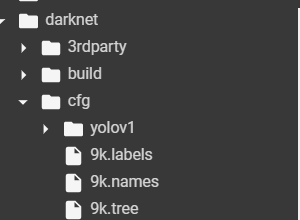

* darknet 폴더 아래 cfg 폴더를 클릭 -> yolo4-csp 더블 클릭

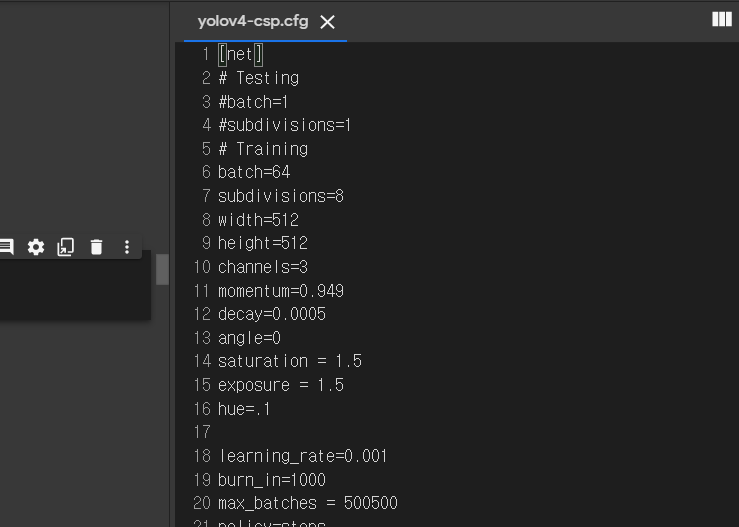

* cfg 파일을 더블클릭하면 파일 내용을 편집/탐색할 수 있도록 사이드에 파일이 열린다.

다음과 같이 yolov4-custom.cgf 파일을 수정한다.
* subdivision = 16
* width = 416
* height = 416
* max_batches = num_classes * 2000 = 2 * 2000 = 4000
* steps = max_batches * 0.8, max_batches * 0.9 = 3200, 3600
* yolo layer 마다 classes=2
* yolo layer 앞에 있는 convolutional layer 마다 filers = (num_classes + 5) * 3 = 21

## 4) weights 다운로드


`!wget [옵션] [url]`
* 웹 상의 파일을 다운로드하는 리눅스 명령어이다.
* wget => web get



In [12]:
%cd /content/darknet/data


# # 이후 이미지 데이터셋을 저장할 경로 지정
# path = "/content/darknet/data/images/"
# # test.txt 생성
# # w 모드로 text 파일을 생성
# f = open('/content/darknet/data/test.txt', 'w')
# for img in os.listdir('/content/drive/MyDrive/object_Detect/split(0.6 0.2 02.)_crop/test'):
#     if img[-3:]=='jpg':
#         # 문자 입력
#         f.write(path+img+"\n")
# f.close()

# # train.txt 생성
# # w 모드로 text 파일을 생성
# f = open('/content/darknet/data/train.txt', 'w')
# for img in os.listdir('/content/drive/MyDrive/object_Detect/split(0.6 0.2 02.)_crop/train'):
#     if img[-3:]=='jpg':
#         # 문자 입력
#         f.write(path+img+"\n")
# f.close()

# # valid.txt 생성
# # w 모드로 text 파일을 생성
# f = open('/content/darknet/data/valid.txt', 'w')
# for img in os.listdir('/content/drive/MyDrive/object_Detect/split(0.6 0.2 02.)_crop/valid'):
#     if img[-3:]=='jpg':
#         # 문자 입력
#         f.write(path+img+"\n")
# f.close()


# 구글 드라이브 파일에서 train.txt을 colab으로 다운로드 
!gdown --id 1iJ5QL2Fbr0MJsKbyjCP-cgbGmKstzzcx

# 구글 드라이브 파일에서 test.txt을 colab으로 다운로드 
!gdown --id 1fPMtsVNN3LioebMQPJiRD8apZiMfPKrc

# 구글 드라이브 파일에서 valid.txt을 colab으로 다운로드
!gdown --id 1O2_-ZdIiUaXxbv0IzgugK1VODwIwi2iZ

# 구글 드라이브 파일에서 weights을 colab으로 다운로드
!gdown --id 1uKppYJNhjTakUx0LY_PcocwNQfoUsoVK

# 구글 드라이브 파일에서 .data를 colab으로 다운로드
!gdown --id 1FY5eOVpipjdIW89fV1dhp5H7bp0wuqhb

/content/darknet/data
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iJ5QL2Fbr0MJsKbyjCP-cgbGmKstzzcx
To: /content/darknet/data/train.txt
100% 5.51M/5.51M [00:00<00:00, 18.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fPMtsVNN3LioebMQPJiRD8apZiMfPKrc
To: /content/darknet/data/test.txt
100% 1.84M/1.84M [00:00<00:00, 223MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  catego

In [13]:
%cat /content/darknet/data/test.txt

/content/darknet/data/images/H_2707.99-1000_01_110.jpg
/content/darknet/data/images/H_2707.99-1000_01_118.jpg
/content/darknet/data/images/H_2707.99-1000_01_120.jpg
/content/darknet/data/images/H_2707.99-1000_01_132.jpg
/content/darknet/data/images/H_2707.99-1000_01_133.jpg
/content/darknet/data/images/H_2707.99-1000_01_140.jpg
/content/darknet/data/images/H_2707.99-1000_01_146.jpg
/content/darknet/data/images/H_2707.99-1000_01_148.jpg
/content/darknet/data/images/H_2707.99-1000_01_150.jpg
/content/darknet/data/images/H_2707.99-1000_01_153.jpg
/content/darknet/data/images/H_2707.99-1000_01_156.jpg
/content/darknet/data/images/H_2707.99-1000_01_158.jpg
/content/darknet/data/images/H_2707.99-1000_01_173.jpg
/content/darknet/data/images/H_2707.99-1000_01_174.jpg
/content/darknet/data/images/H_2707.99-1000_01_185.jpg
/content/darknet/data/images/H_2707.99-1000_01_190.jpg
/content/darknet/data/images/H_2707.99-1000_01_193.jpg
/content/darknet/data/images/H_2707.99-1000_01_194.jpg
/content/d

## 5) darknet 구축

* 기존 파일을 그대로 사용하는 것이 아니라 Makefile을 수정하여 옵션을 변경하여 보자.
* Makefile은 darknet 프로젝트 폴더 내에 존재하며, darknet 구축을 위한 옵션이 저장되어 있다.

(변경 전)

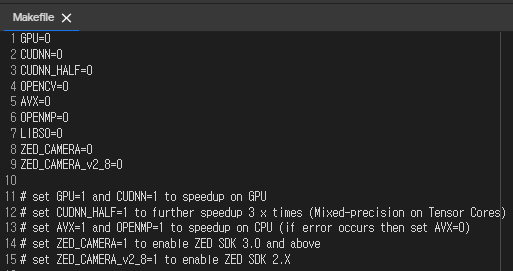

`!sed [옵션] '명령어' [파일] `
* sed는 리눅스 os에서 비대화형 모드로 [파일]에 해당하는 텍스트 파일을 편집한다. 

`-i`
* inplace로 명령어를 수행하는 옵션이다.
* -i.back으로 옵션을 설정할 경우 오리지널 파일의 백업 데이터가 생성된다.

`'s/검색할 문자열/치환할 문자열'`
* s(=subsitute command)는 치환을 수행하는 명령어이다. 
* [파일]에서 조건에 일치하는 문자열을 모두 찾아 치환할 문자열로 대체한다.

In [15]:
%cd /content/darknet

# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


(변경 후)

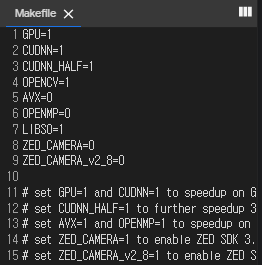

* OpenCV는 오픈 소스 컴퓨터 비전 라이브러리이다. 
* Libso는 so 라이브러리 파일(=동적 라이브러리 파일)을 만드는 옵션이다. LIBSO=1(=True)로 설정하면 darknet.so 파일이 생성되며, 파이썬으로 darknet을 작동시키는 것이 가능해진다.

* darknet을 구축하여보자.
* !make로 Makefile을 컴파일할 수 있다.

In [16]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

## 6) custom dataset으로 transfer learning

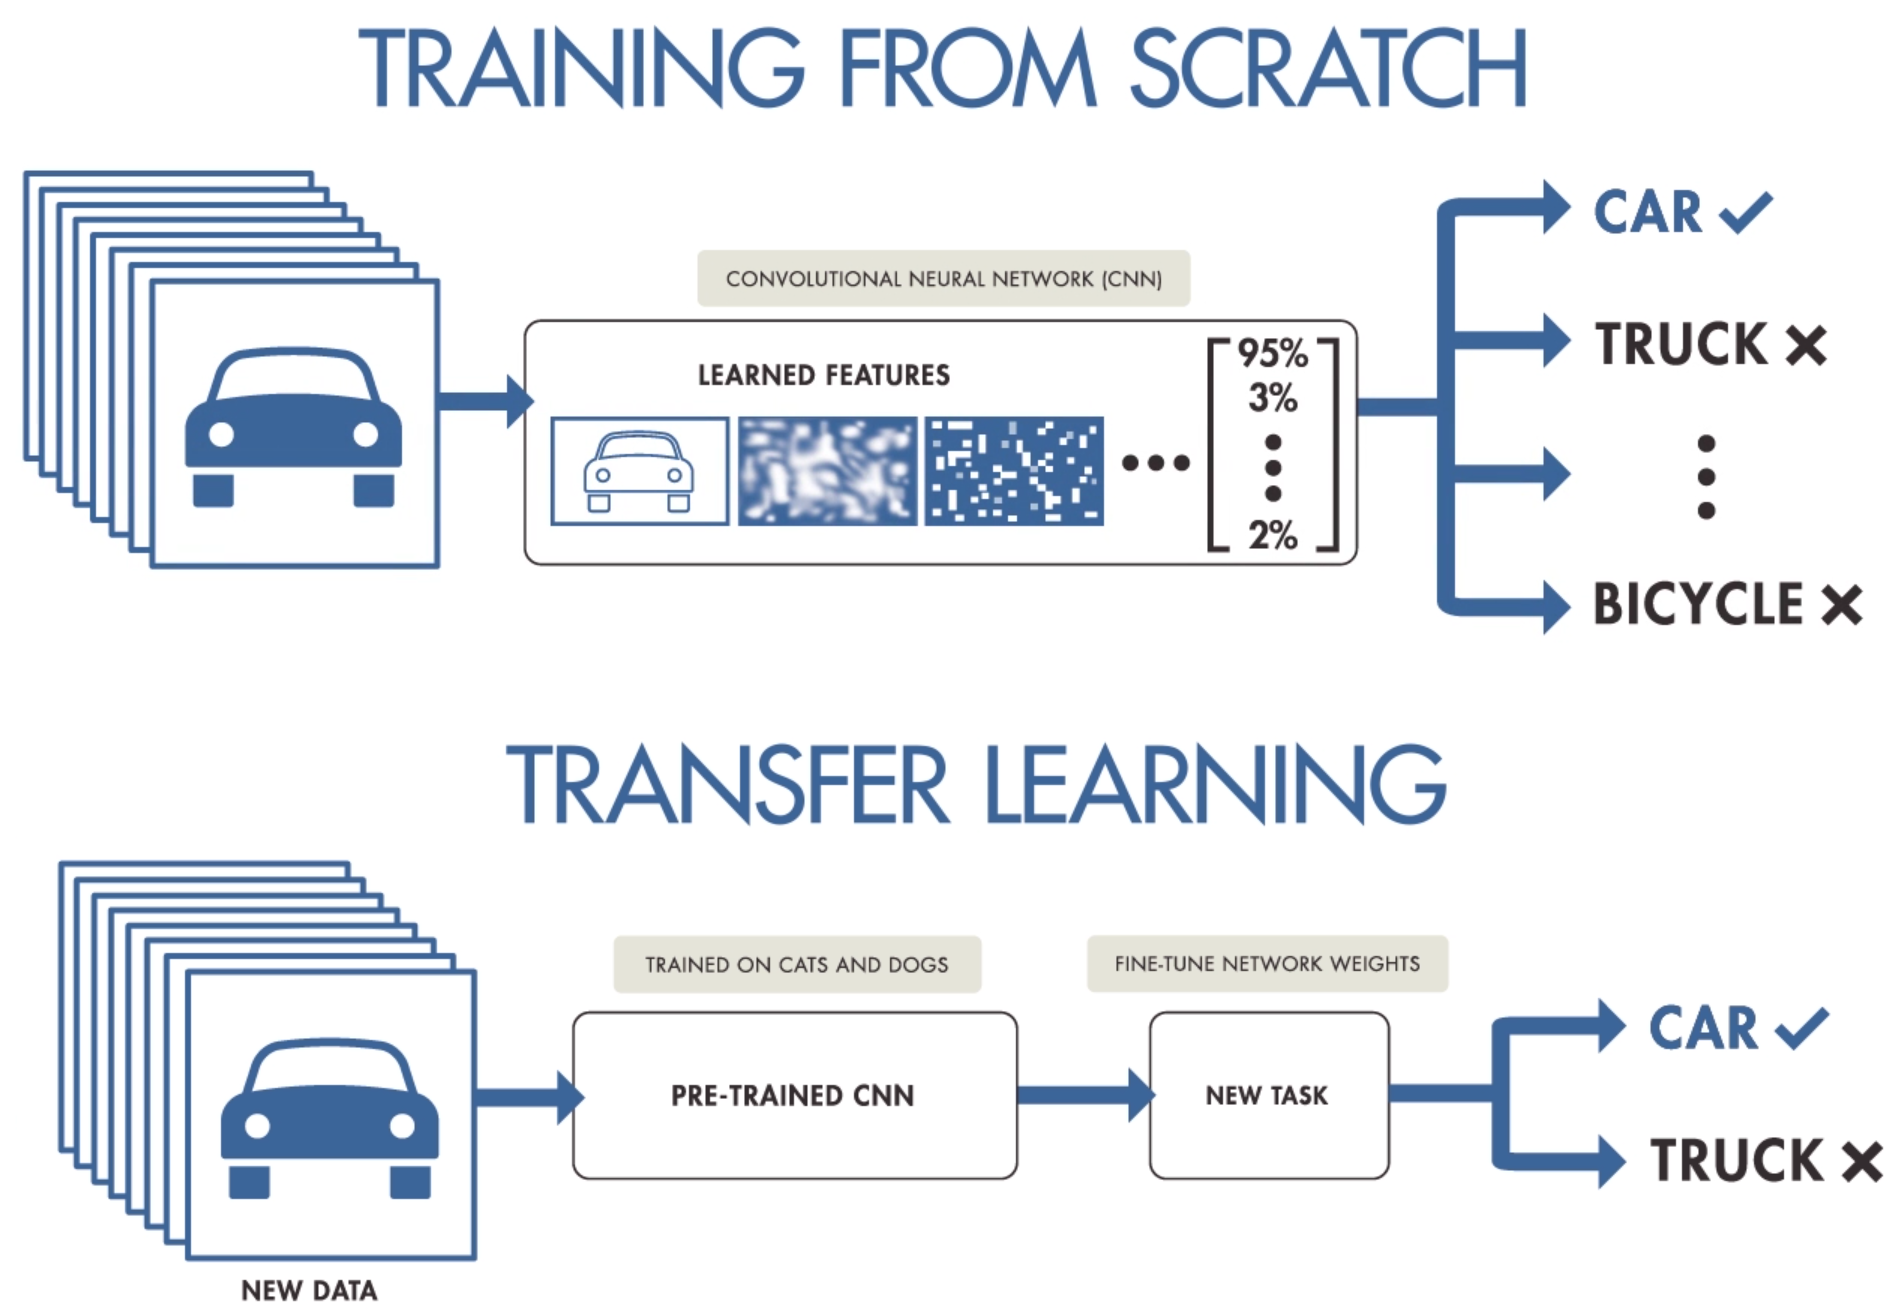

이미지 출처: https://purnasaigudikandula.medium.com/deep-view-on-transfer-learning-with-iamge-classification-pytorch-5cf963939575

In [ ]:
# custom dataset으로 YOLO 학습
!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg data/yolov4-custom_best.weights -dont_show -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.770471), count: 4, class_loss = 0.311830, iou_loss = 0.620151, total_loss = 0.931981 
 total_bbox = 1759868, rewritten_bbox = 0.129896 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.914383), count: 14, class_loss = 0.072044, iou_loss = 18.630596, total_loss = 18.702641 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.883964), count: 19, class_loss = 0.003140, iou_loss = 8.623980, total_loss = 8.627119 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.739423), count: 2, class_loss = 0.218156, iou_loss = 0.085939, total_loss = 0.304095 
 total_bbox = 1759903, rewritten_bbox = 0.129894 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.779295), count: 29, class_loss = 3.175330, iou_loss = 63.258698, total_loss = 66.434029 
v3 (iou 

* 100 iteration 마다 backup 폴더에 yolov4-custom_last.weights으로 weights가 저장된다. 학습이 중간에 중단되는 경우 해당 weights로부터 학습을 재게하면된다. 


In [ ]:
## 학습 재게
# %cd /content/darknet
# !./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg backup/yolov4-custom_last.weights -dont_show -map

## 7) 학습결과 저장

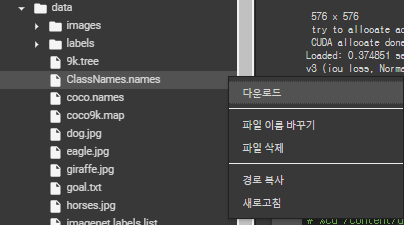

다음 파일을 다운로드한다.
* ClassNames.names
* test.txt
* train.txt
* valid.txt
* mask_data.data
* yolov4_custom_best.weights